## Brief summary of document


This document describes the analysis of a dataset related to the identification of linear B-cell epitopes for *Trypanosoma cruzi* (T. cruzi), a parasite responsible for Chagas' disease. The Jupyter notebook captures Exploratory Data Analysis (EDA), data pre-processing, and the application of machine learning techniques to predict epitopes.

All the random_state values in this Jupyter notebook is assigned as 33 (Last two digits of student number) for unique and replicable process.

### Key Phases

1. **Setup and Data Preparation**
   - Installation of necessary libraries.
   - Data loading from `df_reduced.csv`.
   - Creation of dataset backups.
2. **Exploratory Data Analysis**:
   - Visualisations pertaining to Min-Max ranges of the features, Overall range distribution of the features
   - Visualisations to understand anomalies in the dataset
   
2. **Data Cleaning and Preprocessing**
   - Removal of unnecessary informational columns.
   - Handling missing values and duplicates.
   - Normalization of numerical features using `MinMaxScaler`.
   - Managing outliers using the ABOD  method.

4. **Data Splitting and Resampling**
   - Splitting the dataset into training, validation, and test sets.
   - Feature Selection using VarianceThreshold 
   - Addressing class imbalance using the SMOTE  technique.

5. **Model Building and Evaluation**
   - Evaluation of models such as `RandomForestClassifier`, `LogisticRegression`, and `XGBClassifier` using cross-validation.
   - Optimization through feature selection and class imbalance strategies.

6. **Pipeline and Prediction**
   - Construction of a pipeline  for streamlined data preprocessing and modeling.
   - Validation and testing of the final model to assess generalizability and performance on unseen data.

7. **Holdout Set Prediction**
   - Generation of predictions for a holdout dataset, ensuring the model's robustness and reliability.



## Exploratory Data Analysis and Data Pre-processing

This Jupyter notebook section details the Exploratory Data Analysis (EDA) and data pre-processing for a Data Mining coursework. The key steps include:

1. **Setup**: Installation of essential libraries for data handling, visualization, machine learning, and anomaly detection.

2. **Data Loading and Backup**: The dataset `df_reduced.csv` is loaded into a pandas DataFrame, with a backup created for safety.

3. **Data Cleaning**:
   - Removal of unnecessary informational columns.
   - Calculation of missing values, with thresholds applied to drop columns and rows significantly lacking data (with 50% Missing data).
   - Duplicate removal and data type adjustments for efficiency.

4. **Outlier Management**: Using the ABOD method, outliers are detected and handled by replacing them with median of the column. Anomaly scores are plotted to understand more about the outliers found.

5. **Feature Scaling**: Numerical features are normalized using `MinMaxScaler` to a [0, 1] range. This will ensure that all features contribute equally to the model training process.

6. **Exploratory Data Analysis**:
   - Visualizations to examine feature distributions.
   - Class imbalance of the data is checked.
   - Analysis of feature variances before and after scaling.

7. **Data Splitting and Resampling**:
   - Data is split into training, validation, and test sets considering group structures.
   - Addressing of class imbalance using SMOTE.


In [1]:
!pip install imbalanced-learn
!pip install xgboost
!pip install pyod 

In [2]:
# Importing all the required libraries
import pandas as pd  # Importing the pandas library for data manipulation and analysis
import numpy as np  # Importing the numpy library for numerical operations
import matplotlib.pyplot as plt  # Importing pyplot module from matplotlib for plotting graphs
import seaborn as sns  # Importing seaborn, a statistical data visualization library

from sklearn.ensemble import RandomForestClassifier  # Importing the RandomForest classifier from sklearn
from imblearn.over_sampling import SMOTE  # Importing SMOTE for dealing with class imbalance by oversampling
from sklearn.feature_selection import VarianceThreshold  # Importing VarianceThreshold for feature selection based on variance
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_val_score  # Importing model selection tools from sklearn
from sklearn.preprocessing import MinMaxScaler  # Importing MinMaxScaler for feature scaling
from sklearn.linear_model import LogisticRegression  # Importing the Logistic Regression model from sklearn
from xgboost import XGBClassifier  # Importing XGBoost, an optimized distributed gradient boosting library
from sklearn.metrics import classification_report, balanced_accuracy_score  # Importing metrics for model evaluation
from sklearn.metrics import confusion_matrix, matthews_corrcoef  # Importing additional metrics for model evaluation
from pyod.models.abod import ABOD  # Importing ABOD for anomaly detection based on angle-based outlier detection
from imblearn.pipeline import Pipeline as ImbPipeline  # Importing Pipeline to sequentially apply a list of transforms and a final estimator
from sklearn.model_selection import GridSearchCV  # Importing GridSearchCV for optimizing model parameters


In [ ]:
#Loading the dataset to a dataframe. Delimiter is used as the dataset is not comma separated
dataset_df = pd.read_csv("df_reduced.csv", delimiter=';')
pd.set_option('display.max_columns', None) #in order to display all the variables/columns
dataset_df.head()

In [ ]:
# Creating a backup of the dataset for future purposes, ensuring data integrity throughout various preprocessing steps.
dataset_df_full_bkup = dataset_df.copy()

# Dropping informational columns that are not required for the current analysis
dataset_df = dataset_df.drop(columns=['Info_PepID', 'Info_organism_id', 'Info_protein_id', 'Info_pos', 'Info_AA', 'Info_epitope_id', 'Info_nPos','Info_nNeg'], axis=1)

# Describing the dataset to provide a quick statistical overview of the numerical features, aiding in initial data assessment 
# and understanding.
dataset_df.describe()


In [5]:
#Checking the missing values percentage of the entire dataset as each column has missing values

total_cells = dataset_df.size
total_missing = dataset_df.isnull().sum().sum()  # Sum of all missing values across all columns

# Calculating the percentage of missing values
missing_percentage = (total_missing / total_cells) * 100

print(f"Overall missing value percentage: {missing_percentage:.2f}%")

Overall missing value percentage: 0.41%


In [6]:
#Checking the extent of missing values in each column of the dataset
missing_values_count = dataset_df.isnull().sum()

# Columns which have missing values
missing_values_columns = missing_values_count[missing_values_count > 0].sort_values(ascending=False)

# Calculating the percentage of missing values
missing_values_percentage = (missing_values_columns / len(dataset_df)) * 100

print("Percentage of missing values in each feature column:")
print(missing_values_percentage)

Percentage of missing values in each feature column:
feat_esm1b_148    90.066118
feat_esm1b_0       0.112885
feat_esm1b_137     0.112885
feat_esm1b_139     0.112885
feat_esm1b_141     0.112885
                    ...    
feat_esm1b_181     0.088695
feat_esm1b_270     0.080632
feat_esm1b_114     0.080632
feat_esm1b_277     0.080632
feat_esm1b_119     0.072569
Length: 290, dtype: float64


In [7]:
# The below function cleans the dataset by removing columns and rows with excessive missing values, duplicates,
# and optimizes data types for better memory management and processing speed.
def col_row_manipulations(dataset_df):
    # Defining thresholds (as percentages) for dropping columns and rows
    column_threshold = 0.5  # to drop columns with more than 50% missing values
    row_threshold = 0.5    # to drop rows with more than 50% missing values

    # Dropping columns with many missing values
    columns_to_drop = dataset_df.columns[dataset_df.isnull().mean() > column_threshold]
    print("Columns to drop are  : ", columns_to_drop)
    dataset_df.drop(columns=columns_to_drop, inplace=True)

    # Dropping rows with many missing values
    rows_to_drop = dataset_df.index[dataset_df.isnull().mean(axis=1) > row_threshold]
    dataset_df.drop(index=rows_to_drop, inplace=True)

    # Removing Duplicate Rows
    dataset_df.drop_duplicates(inplace=True)

    # Convert data types for optimal memory and processing efficiency:
    # - Convert integer columns to floats for more flexible data manipulation.
    # - Convert object-type columns with limited unique values
    #   to categories to save memory and improve performance.
    for column in dataset_df.columns:
        if dataset_df[column].dtype == 'int64':
            dataset_df[column] = dataset_df[column].astype('float64')
        elif dataset_df[column].dtype == 'object' and dataset_df[column].nunique() / len(dataset_df) < 0.3:
            dataset_df[column] = dataset_df[column].astype('category')
    if dataset_df.isnull().any().any():
        dataset_df.fillna(value=dataset_df.median(), inplace=True)
    print(dataset_df.info())
    return dataset_df
dataset_df = col_row_manipulations(dataset_df)

Columns to drop are  :  Index(['feat_esm1b_148'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12388 entries, 0 to 12401
Columns: 291 entries, Info_cluster to feat_esm1b_289
dtypes: float64(291)
memory usage: 27.6 MB
None


Number of outliers:  1524


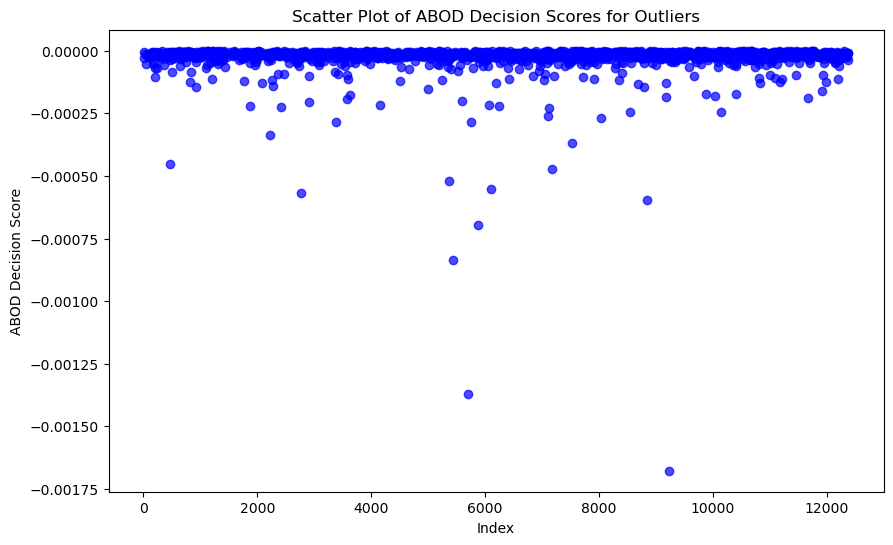

In [8]:
# Checking for outliers in the dataset using the ABOD method
def outlier_handling(dataset_df, plot):
    # Initializing the ABOD classifier.
    abod_clf = ABOD()

    # Fitting the ABOD model to the dataset.
    abod_clf.fit(dataset_df)

    # Storing decision scores for later use.
    outlier_scores = abod_clf.decision_scores_

    # Predicting outliers in the dataset.
    outlier_predictions = abod_clf.predict(dataset_df)

    # Printing the total number of detected outliers.
    print("Number of outliers: ", outlier_predictions.sum())
    
    # Identifying rows that are marked as outliers.
    is_outlier = outlier_predictions == 1
    
    # Calculating the median of each column to use for replacing outliers.
    medians = dataset_df.median()
    
    # Plotting only the decision scores for outliers
    if plot:
        outlier_scores = outlier_scores[is_outlier]  # Selecting only scores of outliers
        plt.figure(figsize=(10, 6))
        plt.scatter(x=np.where(is_outlier)[0], y=outlier_scores, color='blue', alpha=0.7)
        plt.title('Scatter Plot of ABOD Decision Scores for Outliers')
        plt.xlabel('Index')
        plt.ylabel('ABOD Decision Score')
        plt.show()
    
    # Replacing outliers in numerical columns with column medians.
    for col in dataset_df.columns:
        # Ensuring only numerical columns are targeted for replacement.
        if np.issubdtype(dataset_df[col].dtype, np.number):
            dataset_df.loc[is_outlier, col] = medians[col]
    # Returning the modified dataset.
    return dataset_df

# Applying the outlier handling function to the dataset.
handled_dataset_df = outlier_handling(dataset_df, True)

In [9]:
# Taking a backup of the dataframe again before modifying it to avoid losing Info_cluster and Class columns.
dataset_df_info_bkup = dataset_df.copy()

# Dropping 'Info_cluster' and 'Class' columns from the dataframe, as they interfere with visualization.
dataset_df = dataset_df.drop(['Info_cluster', 'Class'], axis=1)

# Printing the number of observations and variables to verify the structure, and checking the data types of remaining columns.
print(f"Number of observations: {dataset_df.shape[0]}")
print(f"Number of variables: {dataset_df.shape[1]}")
print(dataset_df.dtypes)


Number of observations: 12388
Number of variables: 289
feat_esm1b_0      float64
feat_esm1b_1      float64
feat_esm1b_2      float64
feat_esm1b_3      float64
feat_esm1b_4      float64
                   ...   
feat_esm1b_285    float64
feat_esm1b_286    float64
feat_esm1b_287    float64
feat_esm1b_288    float64
feat_esm1b_289    float64
Length: 289, dtype: object


In [10]:
# Selecting columns that are of integer or float data types for visualization purposes.
num_columns = dataset_df.select_dtypes(include=['int64', 'float64']).columns

# Checking whether all columns in the dataset are numeric before proceeding with visualizations.
if len(num_columns) == len(dataset_df.columns):
    print("The dataset contains only numeric columns.")
else:
    print("The dataset contains non-numeric columns as well.")


The dataset contains only numeric columns.


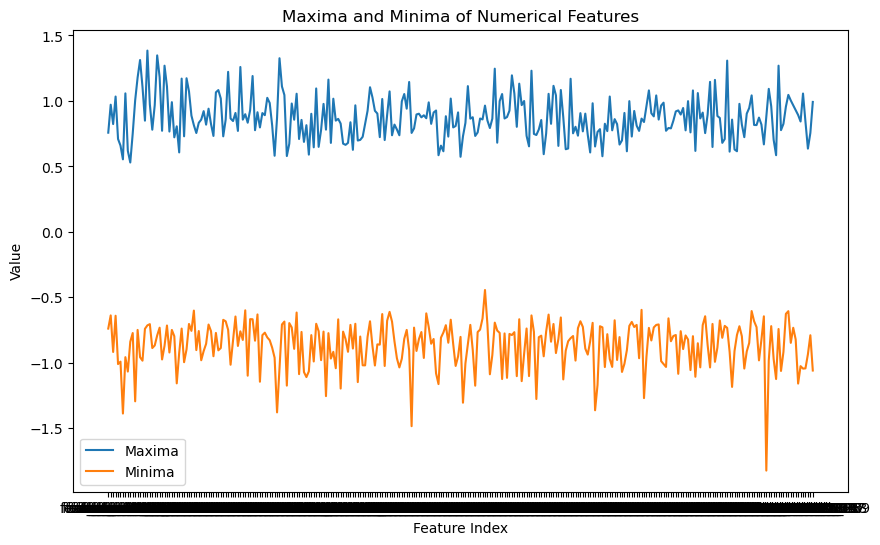

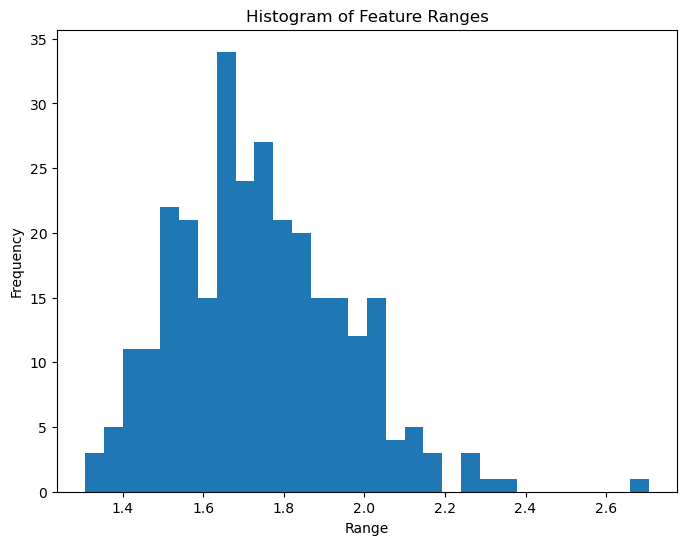

In [11]:
# Calculating maximum and minimum values for each numeric column to determine the range of features.
max_values = dataset_df[num_columns].max()
min_values = dataset_df[num_columns].min()
ranges = max_values - min_values


# Calculating the maximum and minimum values across all columns to assess the scale of features.
max_values = dataset_df.max()
min_values = dataset_df.min()

# Plotting the maximum and minimum values to visualize the distribution of numerical feature scales.
plt.figure(figsize=(10, 6))
plt.plot(max_values, label='Maxima')
plt.plot(min_values, label='Minima')
plt.title('Maxima and Minima of Numerical Features')
plt.xlabel('Feature Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Calculating the range of values (max - min) for each feature to understand dispersion.
ranges = max_values - min_values

# Plotting a histogram of these ranges to visualize the frequency distribution of feature ranges.
plt.figure(figsize=(8, 6))
plt.hist(ranges, bins=30)
plt.title('Histogram of Feature Ranges')
plt.xlabel('Range')
plt.ylabel('Frequency')
plt.show()


In [12]:
# Calculating the counts and percentages of each class in the 'Class' column to check for class imbalance.
class_counts = dataset_df_info_bkup['Class'].value_counts()
class_percentages = dataset_df_info_bkup['Class'].value_counts(normalize=True) * 100

# Displaying the counts and percentages of classes to visualize the distribution and identify potential imbalance.
print("Class counts:\n", class_counts)
print("\nClass percentages:\n", class_percentages)

Class counts:
 -1.0    12214
 1.0      174
Name: Class, dtype: int64

Class percentages:
 -1.0    98.595415
 1.0     1.404585
Name: Class, dtype: float64


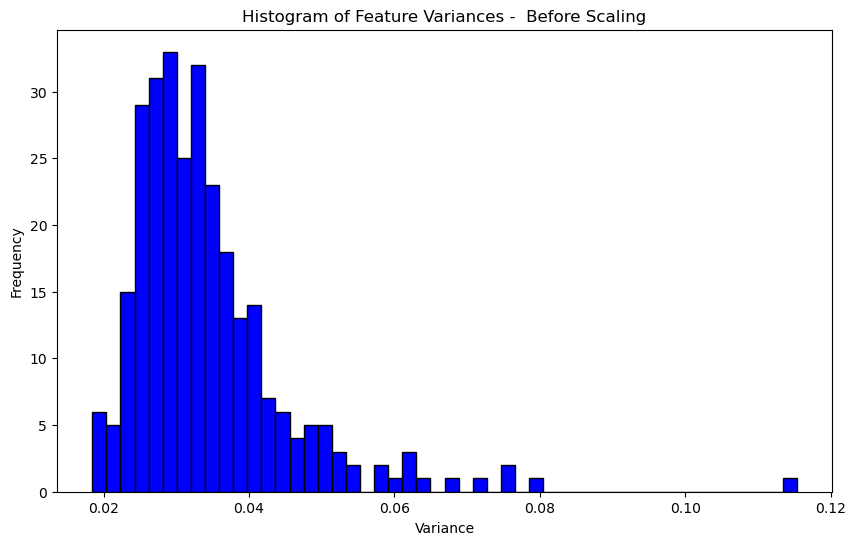

In [13]:
# Calculating the variances of each feature in the dataset to assess data dispersion.
variances = dataset_df.var()

# Plotting a histogram of the feature variances to visualize the distribution of data variability.
plt.figure(figsize=(10, 6))  # Adjust the size to fit the data visualization needs.
plt.hist(variances, bins=50, color='blue', edgecolor='black')  # Choose the number of bins to effectively represent the variance distribution.
plt.title('Histogram of Feature Variances -  Before Scaling')
plt.xlabel('Variance')
plt.ylabel('Frequency')
plt.show()


In [14]:
def check_variance_threshold(variances, variance_threshold):
    """
    Evaluate and count features with variances above a specified threshold to identify significant variability.
    """

    # Identifying features where the variance exceeds the specified threshold.
    features_above_threshold = variances[variances > variance_threshold]

    # Counting the number of features with variance above the threshold to quantify variability.
    num_features_above_threshold = len(features_above_threshold)

    # Printing the count of features with high variance to report on data diversity.
    print(f"Number of features with variance above {variance_threshold}: {num_features_above_threshold}")

# Executing the function to check variance threshold at 0.03. This is done to understand the number of features and get
# an idea of the features required for further processing
check_variance_threshold(variances, 0.03)


Number of features with variance above 0.03: 172


In [15]:
# Restoring 'Info_cluster' and 'Class' columns from the backup dataframe to the processed dataframe for structured grouping 
# and classification.
dataset_df['Info_cluster'] = dataset_df_info_bkup['Info_cluster'].copy()
dataset_df['Class'] = dataset_df_info_bkup['Class'].copy()

# Initializing GroupShuffleSplit for splitting the dataset while observing the grouping structure based on 'Info_cluster'.
gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=33)

# Conducting the first split to separate out the initial training set and the test set, ensuring that similar groups are 
# kept together.
for train_idx, test_idx in gss.split(dataset_df, groups=dataset_df['Info_cluster']):
    train_df_initial = dataset_df.iloc[train_idx]
    test_df = dataset_df.iloc[test_idx]

# Setting up another GroupShuffleSplit to divide the initial training set further into a final training set and a validation set.
gss_validation = GroupShuffleSplit(n_splits=1, train_size=0.75, random_state=33)  # Adjust train_size as needed

# Executing the second split, again observing group structures to maintain integrity of grouped data.
for train_idx, valid_idx in gss_validation.split(train_df_initial, groups=train_df_initial['Info_cluster']):
    train_df = train_df_initial.iloc[train_idx]
    valid_df = train_df_initial.iloc[valid_idx]

# Preparing the feature matrices (X) and target vectors (y) for training, validation, and testing phases.
X_train = train_df.drop(columns=['Class'])
y_train = train_df['Class']

X_valid = valid_df.drop(columns=['Class'])
y_valid = valid_df['Class']

X_test = test_df.drop(columns=['Class'])
y_test = test_df['Class']


In [16]:
# Initializing the MinMaxScaler to scale numerical features into a fixed range of [0, 1], which is required for 
# optimal performance of many machine learning algorithms.
scaler = MinMaxScaler()

# Fitting the scaler to the training data and transforming the training, validation, and test datasets.
X_train_scaled = scaler.fit_transform(X_train)  # Fit to data, then transform it.
X_val_scaled = scaler.transform(X_valid)  # Perform the same transformation on validation data.
X_test_scaled = scaler.transform(X_test)  # Perform the same transformation on test data.

# Converting scaled arrays back to DataFrames for easier handling in the next steps of data processing.
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)  # Retaining original feature names for clarity.
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_valid.columns)  # Ensuring column names are consistent.
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)  # Ensuring column names are consistent.

# Printing a confirmation message to verify that scaling was successfully applied.
print("Training and testing features scaled to the [0, 1] interval.")

Training and testing features scaled to the [0, 1] interval.


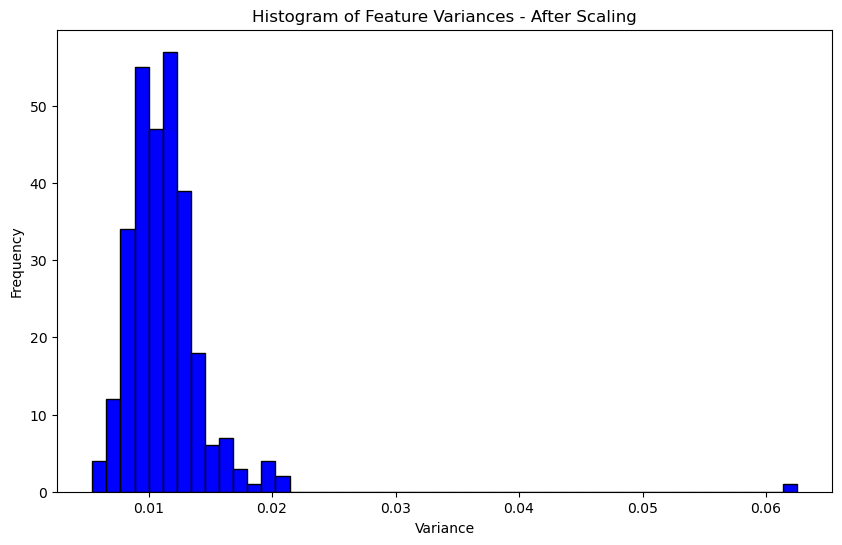

In [17]:
# Calculating the variances of the scaled features in the training dataset to assess data dispersion after resampling
# and scaling.
new_variances = X_train_scaled_df.var()

# Plotting a histogram of the calculated variances to visually inspect the distribution and identify features with 
# low variability, which may not contribute significantly to a model.
plt.figure(figsize=(10, 6)) 
plt.hist(new_variances, bins=50, color='blue', edgecolor='black')  # Using 50 bins to provide a detailed view of the 
                                                                   # variance distribution.
plt.title('Histogram of Feature Variances - After Scaling')
plt.xlabel('Variance') 
plt.ylabel('Frequency')
plt.show()  

In [18]:
# Executing the function to check variance threshold at 0.012. Selected as an initial value to understand the number of features
# required for further processing
check_variance_threshold(new_variances, 0.012)

Number of features with variance above 0.012: 92


## Insights from EDA and Steps Taken During Data Pre-Processing

- **Missing Values Imputation:** Missing values were imputed with respective column medians to preserve data completeness, except where scarcity exceeded 50%, leading to the removal of one column (feat_esm1b_148) to maintain data quality.
- **Duplicate Value Removals:** Duplicate values were checked and removed to mitigate data redundancy issues. 
- **Outlier Treatment:** A total of 1524 outliers were identified and substituted with column medians to mitigate potential skewing of the model's performance.
- **Feature Scaling:** Feature ranges were normalized using Min-Max Scaling to ensure uniformity across all predictors, thereby providing a balanced contribution to the model's learning and predictions.
- **Feature Variance Analysis:** Feature variance analysis revealed a concentration of variances between 0.008 and 0.014, informing the selection of a variance threshold to optimize feature selection via VarianceThreshold.
- **Class Imbalance:** A pronounced class imbalance was observed, with the majority class (-1) significantly outweighing the minority (1). This imbalance will be addressed through the application of SMOTE resampling to foster model equity in handling both classes.
- **Data Splitting Strategy:** Given the group structure the dataset has, around the "Info_cluster" column, we are using GroupShuffleSplit to split the data in Train, Validation and Test data


## Feature reduction

This section outlines the feature reduction process aimed at enhancing model performance by focusing on the most informative features:

1. **Variance-Based Selection**: Features are selected based on a variance threshold of 0.012, identified through earlier analyses to ensure only relevant features are retained.

2. **Dropping Low-Variance Features**: Features falling below this threshold are removed from the dataset, streamlining it for improved computational efficiency and model accuracy.

3. **Applying VarianceThreshold**: A `VarianceThreshold` is utilized to automate the exclusion of low-variance features, ensuring a focused and impactful feature set.

4. **Reconstructing the Dataframe**: A new DataFrame is created from the selected features, preserving essential information and maintaining consistency in data handling, especially with respect to groupings like 'Info_cluster'.


In [19]:
# For initial feature selection, we are considering only features that have a variance above a threshold of 0.012. This decision 
# is based on the observation from the variance analysis performed earlier, where features with low variance are less likely 
# to contribute effectively to predictive models.

# Identifying features with variance below the newly adjusted threshold of 0.012.
features_below_threshold = new_variances[new_variances < 0.012].index.tolist()

# Dropping the identified low-variance features from the training dataset to focus on more informative features.
dataset_df_variance_filtered = X_train_scaled_df.drop(columns=features_below_threshold)

# Printing the new shape of the dataset to verify the number of features remaining after low-variance feature removal.
print(dataset_df_variance_filtered.shape)

(7675, 92)


In [20]:
# Initializing the VarianceThreshold selector to filter out features with a variance below 0.012. 
# This threshold is chosen based on prior analysis indicating it as a cutoff for low variability 
# features which may not contribute to model effectiveness.
selector = VarianceThreshold(threshold=0.012) 

# Fitting the selector to the scaled training data. This step calculates the variance of each feature 
# in the dataset to prepare for the subsequent filtering.
selector.fit(X_train_scaled_df)

# Transforming the dataset to reduce it to features with variances above the threshold, effectively 
# removing less informative features.
X_selected = selector.transform(X_train_scaled_df)

# Retrieving the mask of the selected features. This boolean array indicates which features have 
# passed the variance threshold.
features_mask = selector.get_support()

# Extracting the names of the high-variance features using the mask, ensuring we maintain the feature names 
# for interpretability.
high_variance_feature_names = X_train_scaled_df.columns[features_mask]

# Creating a new DataFrame with the selected features, using the original feature names for clarity and further analysis.
X_train_selected = pd.DataFrame(X_selected, columns=high_variance_feature_names)

# Extracting the 'Info_cluster' groups for use in further split or analysis, ensuring consistency 
# with the original data grouping.
groups_train = X_train_selected['Info_cluster']

# Removing Info_cluster from the training data as it is not required and this dataframe will be used for Pipeline fitting
# It should not contain info_cluster then

X_train_scaled_df = X_train_scaled_df.drop('Info_cluster', axis=1)


## Addressing class imbalance

This section outlines the steps taken to address class imbalance, ensuring fair representation of both classes in the dataset:

1. **SMOTE Resampling**: Employed SMOTE with a sampling strategy of 0.5 and `k_neighbors` set to 3 for oversampling the minority class, ensuring balanced representation.

2. **Data Normalization**: Replaced -1 with 0 in class labels for both original and resampled datasets for compatibility with algorithms.

3. **Feature Set Simplification**: Dropped 'Info_cluster' column from all datasets to streamline the feature set for machine learning models.

In [21]:
# Initializing SMOTE (Synthetic Minority Over-sampling Technique) to balance the dataset by over-sampling the minority class.
# Setting the sampling strategy to 0.5, meaning the number of minority class samples will be 50% of the majority class after 
# resampling.
# Specifying `random_state` for reproducibility and `k_neighbors` to use three nearest neighbors for generating synthetic 
# samples.
smote = SMOTE(sampling_strategy=0.5, random_state=33, k_neighbors=3)

# Applying SMOTE to resample the dataset, addressing class imbalance by synthetically augmenting the minority class.
X_resampled, y_resampled = smote.fit_resample(X_train_selected, y_train)

# Extracting 'Info_cluster' from the resampled data for potential use in further analysis or split strategies.
groups_train_resampled = X_resampled['Info_cluster']

# Normalizing the class labels in the original and resampled datasets by replacing -1 with 0, often necessary for compatibility
# with XGBoost model.
y_train_normalised = y_train.replace(-1,0)
y_resampled_normalised = y_resampled.replace(-1,0)

# Dropping 'Info_cluster' from all datasets to simplify the feature set for machine learning models.
X_train_selected = X_train_selected.drop('Info_cluster', axis=1)
X_resampled = X_resampled.drop('Info_cluster', axis=1)
X_valid = X_val_scaled_df.drop('Info_cluster', axis=1)
X_test = X_test_scaled_df.drop('Info_cluster', axis=1)


## Model fitting

This section describes the process of fitting several models to imbalanced and balanced datasets using cross-validation and evaluating their performance based on balanced accuracy scores. The models included are RandomForestClassifier, LogisticRegression, and XGBClassifier. GroupKFold is utilized to ensure independence in data splits, with special attention given to handling the unique requirements of the XGBClassifier. 

Key steps include:
- **Initialization of GroupKFold:** Split the dataset into 5 folds ensuring no group leakage between training and testing sets.
- **Dictionary of Models:** Set specific configurations for each model to cater to different training and prediction needs.
- **Cross-Validation Process:** Evaluate models using the balanced accuracy metric by fitting models multiple times to various dataset partitions.
- **Validation on Independent Data:** Use a separate validation dataset to test model generalization and identify the best performing model based on balanced accuracy.
- **Additional Metrics:** Generate classification reports, confusion matrices, and Matthews Correlation Coefficients to provide a comprehensive assessment of model performance.

These steps help to ascertain model effectiveness in handling both balanced and imbalanced data scenarios, providing insights into which models perform best under different conditions.


In [22]:
# Initializing GroupKFold for splitting the dataset into 5 folds, ensuring that the same group is not
# represented in both training and testing sets across any of the splits.
gkf_imbalanced = GroupKFold(n_splits=5)

# Defining a dictionary of models for evaluation. Each model is set up with specific configurations to 
# handle various aspects of training and prediction.
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=33),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=33),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=33)
}

# Iterating through each model, performing cross-validation to evaluate the performance of models 
# using balanced accuracy as the scoring metric. This process involves fitting models multiple times to
# different partitions of the dataset.
for name, model in models.items():
    # Applying cross-validation, specifically handling the XGBClassifier differently due to its unique requirements 
    #for evaluation metrics.
    cv_scores_imbalanced = cross_val_score(model, X_train_selected, y_train_normalised, groups=groups_train, cv=gkf_imbalanced, scoring='balanced_accuracy', n_jobs=-1)
    
    # Printing the average and standard deviation of the balanced accuracy scores, providing insights into model 
    # performance on the imbalanced dataset.
    print(f"{name} - CV Balanced Accuracy - Imbalanced Dataset: {np.mean(cv_scores_imbalanced):.4f} ± {np.std(cv_scores_imbalanced):.4f}")


RandomForestClassifier - CV Balanced Accuracy - Imbalanced Dataset: 0.6000 ± 0.2000
LogisticRegression - CV Balanced Accuracy - Imbalanced Dataset: 0.6282 ± 0.1938
XGBClassifier - CV Balanced Accuracy - Imbalanced Dataset: 0.6285 ± 0.1938


In [23]:
# Initializing GroupKFold for balanced cross-validation with 5 splits. This ensures that the same group 
# is not split across both training and test sets, maintaining independence and reliability of evaluation.
gkf_balanced = GroupKFold(n_splits=5)

# Defining a dictionary of models, each configured with specific settings for random state and other parameters 
# suitable for handling different aspects of model training and evaluation.
models = {
    'RandomForestClassifier': RandomForestClassifier(random_state=33),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=33),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=33)
}

# Iterating through each defined model to fit them on the resampled dataset and evaluate using balanced cross-validation.
for name, model in models.items():
    # Fitting each model on the resampled dataset. XGBoost uses normalized labels due to its specific requirements.
    if name == 'XGBClassifier':
        model.fit(X_resampled, y_resampled_normalised)
    else:
        model.fit(X_resampled, y_resampled)

    # Evaluating the model using cross-validation, applying GroupKFold to maintain data grouping. Different label 
    # sets are used for XGBoost.
    if name == 'XGBClassifier':
        cv_scores = cross_val_score(model, X_resampled, y_resampled_normalised, groups=groups_train_resampled, cv=gkf_balanced, scoring='balanced_accuracy', n_jobs=-1)
    else:
        cv_scores = cross_val_score(model, X_resampled, y_resampled, groups=groups_train_resampled, cv=gkf_balanced, scoring='balanced_accuracy', n_jobs=-1)
    
    # Printing the calculated mean and standard deviation of balanced accuracy scores for each model, providing a 
    # metric for model performance on the balanced dataset.
    print(f"{name} - CV Balanced Accuracy - Balanced Dataset: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")


RandomForestClassifier - CV Balanced Accuracy - Balanced Dataset: 0.8627 ± 0.1025
LogisticRegression - CV Balanced Accuracy - Balanced Dataset: 0.8133 ± 0.0551
XGBClassifier - CV Balanced Accuracy - Balanced Dataset: 0.8863 ± 0.0916


In [24]:
# Ensuring that the validation dataset has the same feature columns as the training dataset.
X_validation = X_valid[X_resampled.columns].copy()

# Initializing a dictionary to store the validation scores for each model.
validation_scores = {}

# Iterating over each model defined in the models dictionary, fitting them on the resampled training dataset, 
# and predicting on the validation set.
for name, model in models.items():
    # Fitting each model on the resampled dataset. XGBoost uses normalized labels due to its specific requirements, 
    # while other models use the original labels.
    if name == 'XGBClassifier':
        model.fit(X_resampled, y_resampled_normalised)
    else:
        model.fit(X_resampled, y_resampled)

    # Predicting the class labels on the validation dataset.
    y_valid_pred = model.predict(X_validation)

    # For XGBoost, converting predictions back to the original class labels (-1 and 1) if necessary.
    if name == 'XGBClassifier':
        y_valid_pred = np.where(y_valid_pred == 1, 1, -1)
    
    # Calculating the balanced accuracy score for predictions to evaluate model performance on the validation set.
    valid_score = balanced_accuracy_score(y_valid, y_valid_pred)
    print(f"{name} - Validation Balanced Accuracy: {valid_score:.4f}")

    # Storing each model's validation score in the dictionary for later comparison.
    validation_scores[name] = valid_score

# Determining the best performing model based on the highest balanced accuracy score from the validation phase.
best_model = max(validation_scores, key=validation_scores.get)
print(f"Best model based on validation balanced accuracy: {best_model}")


RandomForestClassifier - Validation Balanced Accuracy: 0.5102
LogisticRegression - Validation Balanced Accuracy: 0.6315
XGBClassifier - Validation Balanced Accuracy: 0.5617
Best model based on validation balanced accuracy: LogisticRegression


In [25]:
# Setting up the Logistic Regression model with L2 regularization, a regularization strength of 0.01, 
# a high iteration limit for convergence
model = LogisticRegression(penalty='l2', C=0.01, max_iter=1000, random_state=33)

# Fitting the model to the resampled dataset.
model.fit(X_resampled, y_resampled)

# Predicting the labels for the training set using the trained model to assess its performance on the data it was trained on.
y_train_pred = model.predict(X_resampled)

# Printing a classification report that includes key metrics such as precision, recall, and F1-score for the 
# training predictions.
print(classification_report(y_resampled, y_train_pred))

# Calculating the balanced accuracy score to evaluate the model's effectiveness across both classes, 
balanced_accuracy_train = balanced_accuracy_score(y_resampled, y_train_pred)
print(f"Balanced Accuracy: {balanced_accuracy_train:.4f}")

# Generating a confusion matrix to visually inspect the model's performance in terms of true positives, 
# true negatives, false positives, and false negatives.
conf_matrix_train = confusion_matrix(y_resampled, y_train_pred)
print("Confusion Matrix:")
print(conf_matrix_train)

# Computing the Matthews Correlation Coefficient (MCC) to provide a single measure of the model's quality, 
# considering all four quadrants of the confusion matrix.
mcc_train = matthews_corrcoef(y_resampled, y_train_pred)
print("Matthews Correlation Coefficient:", mcc_train)

              precision    recall  f1-score   support

        -1.0       0.84      0.97      0.90      7583
         1.0       0.91      0.64      0.75      3791

    accuracy                           0.86     11374
   macro avg       0.88      0.80      0.83     11374
weighted avg       0.87      0.86      0.85     11374

Balanced Accuracy: 0.8045
Confusion Matrix:
[[7353  230]
 [1367 2424]]
Matthews Correlation Coefficient: 0.6788310820440111


In [26]:
# Ensuring the validation data has the same feature set as the resampled training data by copying the relevant columns.
X_valid_selected = X_valid[X_resampled.columns].copy()

# Predicting the class labels for the validation dataset using the trained model to evaluate its performance on unseen data.
y_valid_pred = model.predict(X_valid_selected)

# Printing a classification report that includes precision, recall, and F1-score to give a detailed view of model performance 
# across different classes.
print(classification_report(y_valid, y_valid_pred))

# Calculating the balanced accuracy score, which is particularly informative for imbalanced datasets, to measure the model's 
# accuracy across all classes.
balanced_accuracy_valid = balanced_accuracy_score(y_valid, y_valid_pred)
print(f"Balanced Accuracy: {balanced_accuracy_valid:.4f}")

# Generating a confusion matrix to provide a detailed breakdown of true positives, true negatives, false positives, 
# and false negatives.
conf_matrix_valid = confusion_matrix(y_valid, y_valid_pred)
print("Confusion Matrix:")
print(conf_matrix_valid)

# Computing the Matthews Correlation Coefficient (MCC) to provide a single measure of the model's overall quality, 
# reflecting true and false positives and negatives.
mcc_valid = matthews_corrcoef(y_valid, y_valid_pred)
print("Matthews Correlation Coefficient:", mcc_valid)


              precision    recall  f1-score   support

        -1.0       0.99      0.96      0.98      2384
         1.0       0.26      0.69      0.38        48

    accuracy                           0.96      2432
   macro avg       0.63      0.82      0.68      2432
weighted avg       0.98      0.96      0.97      2432

Balanced Accuracy: 0.8245
Confusion Matrix:
[[2292   92]
 [  15   33]]
Matthews Correlation Coefficient: 0.40876998875900755


## Consolidate the Data Mining Pipeline 

This section outlines the construction of a pipeline to streamline the data preprocessing and modeling processes for a logistic regression model. The pipeline integrates feature scaling, feature selection, and model training into a single automated process, facilitated by `Pipeline` from `sklearn`.

Key steps and features include:
- **Pipeline Construction:** Composed of a scaler to normalize features, a variance threshold selector for feature selection, and a logistic regression model for prediction.
- **Hyperparameter Tuning:** Utilizing `GridSearchCV` with a defined parameter grid for logistic regression and feature selection, optimizing for balanced accuracy to identify the most effective model settings.
- **Model Evaluation:** After fitting, the best model configuration is evaluated on resampled data. Metrics like balanced accuracy, classification reports, confusion matrices, and Matthews Correlation Coefficients are calculated to assess performance.
- **Validation Assessment:** The pipeline is further validated on a separate dataset to ensure that the model performs well on unseen data. Classification metrics are generated to evaluate predictive accuracy.


In [27]:
# Constructing a Pipeline to streamline preprocessing and modeling by:
pipeline = ImbPipeline(steps=[
    # Adding a 'scaler' step to normalize all numerical features to a range between 0 and 1
    ('scaler', MinMaxScaler()),
    
    # Integrating 'feature_selection' by adding VarianceThreshold
    # Automatically filtering out features based on variance thresholding before modeling.
    ('feature_selection', VarianceThreshold()),
    
    # Integrating 'smote' into the pipeline using the SMOTE 
    # Automatically resampling the data while training.
    ('smote', SMOTE(random_state=33, sampling_strategy=0.5)),
    
    # Specifying 'model' as the final step of the pipeline, using the logistic regression model, with a similar setup to
    #to the model used earlier. 
    # Allowing for seamless model fitting and predictions with automatic handling of feature scaling and selection.
    ('model', LogisticRegression(penalty='l2', max_iter=1000, random_state=33))
])




In [28]:
# Defining the parameter grid to explore different combinations of hyperparameters for the logistic regression model
# and the feature selection step.
param_grid = {
    'model__C': [0.001, 0.005],  # Regularization strengths to control the degree of shrinkage: 
                                # lower values specify stronger regularization. Selected values because of overfitting 
                                #observed for 0.01
    'model__solver':['newton-cg', 'sag','saga'],
    'smote__k_neighbors':[3,5],
    'feature_selection__threshold': [0.009, 0.01, 0.011, 0.012] # Variance thresholds for feature selection, decided
                                                            # based on the variance distribution analysis.
}

# Setting up the GridSearchCV with the pipeline, parameter grid, and specifying the number of folds for cross-validation. 
# The scoring is set to 'balanced_accuracy' as it is the metric that needs to be used for performance assessment of the 
# pipeline
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='balanced_accuracy', verbose=0, n_jobs=-1)

# Fitting the grid search to the resampled data. This will test all combinations of parameters defined in param_grid.
grid_search.fit(X_train_scaled_df, y_train)

# Printing the best parameters and the highest score achieved during the grid search. This helps identify the most 
# effective model configuration.
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Extracting the best model directly from grid_search for further analysis or deployment.
best_model = grid_search.best_estimator_

# Predicting training data labels using the best model to evaluate its performance on the same data it was trained on.
pipeline_y_pred_train = best_model.predict(X_train_scaled_df)

# Printing a classification report for the predictions to provide a detailed view of the main classification metrics.
print(classification_report(y_train, pipeline_y_pred_train))

# Calculating and printing the balanced accuracy score, which offers an insight into the effectiveness of the model 
# across both classes.
pipeline_balanced_accuracy_train = balanced_accuracy_score(y_train, pipeline_y_pred_train)
print(f"Training Balanced Accuracy: {pipeline_balanced_accuracy_train:.4f}")

# Generating and printing the confusion matrix to observe the number of correct and incorrect predictions across classes.
pipeline_conf_matrix_train = confusion_matrix(y_train, pipeline_y_pred_train)
print("Training Confusion Matrix:")
print(pipeline_conf_matrix_train)

# Calculating and printing the Matthews Correlation Coefficient (MCC), a comprehensive metric that uses all 
# four quadrants of the confusion matrix.
pipeline_mcc_train = matthews_corrcoef(y_train, pipeline_y_pred_train)
print("Training Matthews Correlation Coefficient:", pipeline_mcc_train)


Best parameters: {'feature_selection__threshold': 0.009, 'model__C': 0.005, 'model__solver': 'newton-cg', 'smote__k_neighbors': 5}
Best score: 0.7617349075020943
              precision    recall  f1-score   support

        -1.0       1.00      0.97      0.98      7583
         1.0       0.21      0.68      0.32        92

    accuracy                           0.97      7675
   macro avg       0.60      0.83      0.65      7675
weighted avg       0.99      0.97      0.97      7675

Training Balanced Accuracy: 0.8270
Training Confusion Matrix:
[[7349  234]
 [  29   63]]
Training Matthews Correlation Coefficient: 0.3689727058721255


In [29]:
# Predicting class labels for the validation dataset using the optimized model from the pipeline.
pipeline_valid_y_pred = best_model.predict(X_valid)

# Displaying the classification report to review precision, recall, f1-score, and support for each class, 
# which helps in assessing model performance more granitely.
print("Validation Classification Report (Pipeline):")
print(classification_report(y_valid, pipeline_valid_y_pred))

# Calculating the balanced accuracy score to measure how well the model has performed on both classes of the
# validation data, which is useful in imbalanced datasets.
pipeline_valid_balanced_accuracy = balanced_accuracy_score(y_valid, pipeline_valid_y_pred)
print(f"Validation Balanced Accuracy (Pipeline): {pipeline_valid_balanced_accuracy:.4f}")

# Generating and displaying the confusion matrix to visualize the correct and incorrect predictions across
# both classes, providing insights into model accuracy.
pipeline_valid_conf_matrix = confusion_matrix(y_valid, pipeline_valid_y_pred)
print("Validation Confusion Matrix (Pipeline):")
print(pipeline_valid_conf_matrix)


# Computing and displaying the Matthews correlation coefficient, which provides a comprehensive measure of the model's 
# quality, considering all parts of the confusion matrix.
pipeline_valid_mcc = matthews_corrcoef(y_valid, pipeline_valid_y_pred)
print("Validation Matthews Correlation Coefficient (Pipeline):", pipeline_valid_mcc)


Classification Report (Pipeline):
              precision    recall  f1-score   support

        -1.0       0.99      0.96      0.98      2384
         1.0       0.29      0.73      0.41        48

    accuracy                           0.96      2432
   macro avg       0.64      0.85      0.70      2432
weighted avg       0.98      0.96      0.97      2432

Balanced Accuracy (Pipeline): 0.8465
Confusion Matrix (Pipeline):
[[2298   86]
 [  13   35]]
Matthews Correlation Coefficient (Pipeline): 0.4433763251020249


## Performance evaluation on test split

This section highlights the evaluation of the best-performing model from the pipeline on a separate test dataset. This process is essential to understand the model's capability to generalize to new, unseen data, ensuring robustness and reliability in predictions.

Key steps and features include:
- **Feature Alignment:** Ensuring that the test dataset features match those used during training to prevent discrepancies in model input.
- **Prediction and Evaluation:** Using the best model to predict class labels and, if supported, predict probabilities for the positive class. This dual approach aids in assessing both the hard classification outcomes and the confidence levels of predictions.
- **Metric Calculation:** Generating a comprehensive set of performance metrics including:
  - **Classification Report:** Detailed metrics such as precision, recall, and f1-score.
  - **Balanced Accuracy Score:** Reflects the effectiveness of the model across both classes, crucial for imbalanced datasets.
  - **Confusion Matrix:** Visual representation of the actual versus predicted classifications.
  - **Matthews Correlation Coefficient:** A balanced measure using all four quadrants of the confusion matrix.
- **Visualization:** Plotting balanced accuracy scores across training, validation, and testing stages to visually compare performance and identify consistency or variance in model effectiveness.

This evaluation not only quantifies the model's performance but also provides visual and statistical insights into how well the model handles real-world data, guiding decisions on potential model adjustments or acceptance for deployment.

In [30]:
# Predicting class labels for the test dataset using the best model from the pipeline to evaluate its performance on new, 
# unseen data.
pipeline_y_pred = best_model.predict(X_test)

# Displaying a classification report that includes precision, recall, f1-score, and support for each class. This helps in 
# detailed assessment of model performance.
print("Testing Classification Report (Pipeline):")
print(classification_report(y_test, pipeline_y_pred))

# Calculating the balanced accuracy score to measure how well the model performs across both classes, which is particularly 
# useful in imbalanced data scenarios.
pipeline_balanced_accuracy = balanced_accuracy_score(y_test, pipeline_y_pred)
print(f"Testing Balanced Accuracy (Pipeline): {pipeline_balanced_accuracy:.4f}")

# Generating and displaying the confusion matrix to visualize the actual versus predicted classifications, providing insights 
# into the model's accuracy and misclassifications.
pipeline_conf_matrix = confusion_matrix(y_test, pipeline_y_pred)
print("Testing Confusion Matrix (Pipeline):")
print(pipeline_conf_matrix)

# Computing the Matthews correlation coefficient, which provides a comprehensive measure of the model's quality, taking
# into account true and false positives and negatives.
pipeline_mcc = matthews_corrcoef(y_test, pipeline_y_pred)
print("Testing Matthews Correlation Coefficient (Pipeline):", pipeline_mcc)


Classification Report (Pipeline):
              precision    recall  f1-score   support

        -1.0       0.99      0.90      0.94      2247
         1.0       0.08      0.62      0.15        34

    accuracy                           0.89      2281
   macro avg       0.54      0.76      0.55      2281
weighted avg       0.98      0.89      0.93      2281

Balanced Accuracy (Pipeline): 0.7579
Confusion Matrix (Pipeline):
[[2018  229]
 [  13   21]]
Matthews Correlation Coefficient (Pipeline): 0.20005125656429446


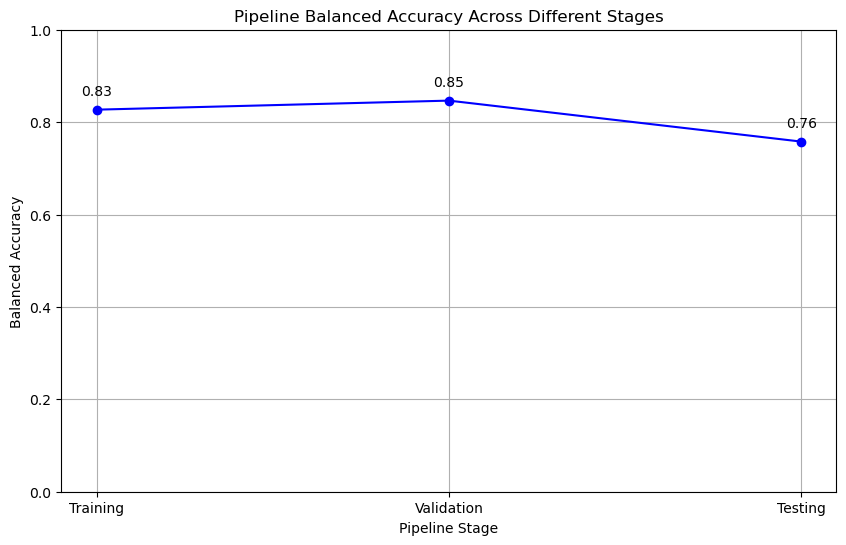

In [31]:
# Initialize balanced accuracy scores from the training, validation, and testing phases.
balanced_accuracies = [pipeline_balanced_accuracy_train, pipeline_valid_balanced_accuracy, pipeline_balanced_accuracy]
labels = ["Training", "Validation", "Testing"]

# Creating a plot figure with specified dimensions for better visibility.
plt.figure(figsize=(10, 6))

# Plotting balanced accuracy scores for each pipeline stage with markers and lines for visual clarity.
plt.plot(labels, balanced_accuracies, marker='o', linestyle='-', color='b')

# Adding a title and axis labels to the plot to specify the content and context of the data being visualized.
plt.title('Pipeline Balanced Accuracy Across Different Stages')
plt.ylabel('Balanced Accuracy')
plt.xlabel('Pipeline Stage')

# Setting the y-axis limit to range from 0 to 1, aligning with the potential range of balanced accuracy scores.
plt.ylim(0, 1)

# Annotating each point on the plot with its corresponding balanced accuracy value to provide 
# immediate readability of exact scores.
for i, acc in enumerate(balanced_accuracies):
    plt.annotate(f'{acc:.2f}', (labels[i], balanced_accuracies[i]), textcoords="offset points", xytext=(0,10), ha='center')


plt.grid(True)
plt.show()


## Generation of predictions on holdout set


This section demonstrates the process of generating predictions for a holdout dataset, using the best-performing model from earlier evaluations. It focuses on ensuring the integrity and suitability of the holdout data for making reliable predictions.

Key steps and features include:
- **Data Loading and Preparation:** 
- The holdout dataset is imported from a CSV file, configured in pandas to display all columns, and cleaned by removing non-predictive information and applying functions to handle missing values and outliers.
- **Feature Alignment:** Ensure that the feature set of the holdout dataset matches the features used by the model during training.
- **Model Predictions:** Apply the best model to the cleaned and aligned holdout dataset to generate predictions.
- **Output Preparation:** Attach predictions to the original holdout dataset and save the results as a new CSV file.
- **Analysis of Predictions:**
  - **Class Counts and Percentages:** Calculate and print the distribution of predicted classes to understand the model's decision-making on the new data.

In [32]:
# Loading the holdout dataset from a CSV file, specifying the delimiter to correctly parse the data.
holdout_df = pd.read_csv("df_reduced_holdout.csv", delimiter=';')

pd.set_option('display.max_columns', None)

# Dropping non-predictive information columns from the DataFrame.
holdout_df_preprocessed = holdout_df.drop(columns=['Info_PepID', 'Info_organism_id', 'Info_protein_id', 'Info_pos', 'Info_AA', 'Info_epitope_id', 'Info_nPos','Info_nNeg','Info_cluster'], axis=1)

# Applying the previously defined function 'col_row_manipulations' to further clean the data 
# by removing columns and rows based on specific thresholds of missing values. This helps in reducing 
# dimensionality and improving dataset quality.
holdout_df_preprocessed = col_row_manipulations(holdout_df_preprocessed)

# Applying the 'outlier_handling' function to detect and mitigate outliers in the dataset. This method uses 
# statistical techniques to identify and neutralize the effects of extreme values that could distort the model's performance.
holdout_df_preprocessed = outlier_handling(holdout_df_preprocessed, False)
holdout_df_preprocessed.head()

Columns to drop are  :  Index([], dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5612 entries, 1 to 5612
Columns: 290 entries, feat_esm1b_0 to feat_esm1b_289
dtypes: float64(290)
memory usage: 12.5 MB
None
Number of outliers:  649


,feat_esm1b_0,feat_esm1b_1,feat_esm1b_2,feat_esm1b_3,feat_esm1b_4,feat_esm1b_5,feat_esm1b_6,feat_esm1b_7,feat_esm1b_8,feat_esm1b_9,feat_esm1b_10,feat_esm1b_11,feat_esm1b_12,feat_esm1b_13,feat_esm1b_14,feat_esm1b_15,feat_esm1b_16,feat_esm1b_17,feat_esm1b_18,feat_esm1b_19,feat_esm1b_20,feat_esm1b_21,feat_esm1b_22,feat_esm1b_23,feat_esm1b_24,feat_esm1b_25,feat_esm1b_26,feat_esm1b_27,feat_esm1b_28,feat_esm1b_29,feat_esm1b_30,feat_esm1b_31,feat_esm1b_32,feat_esm1b_33,feat_esm1b_34,feat_esm1b_35,feat_esm1b_36,feat_esm1b_37,feat_esm1b_38,feat_esm1b_39,feat_esm1b_40,feat_esm1b_41,feat_esm1b_42,feat_esm1b_43,feat_esm1b_44,feat_esm1b_45,feat_esm1b_46,feat_esm1b_47,feat_esm1b_48,feat_esm1b_49,feat_esm1b_50,feat_esm1b_51,feat_esm1b_52,feat_esm1b_53,feat_esm1b_54,feat_esm1b_55,feat_esm1b_56,feat_esm1b_57,feat_esm1b_58,feat_esm1b_59,feat_esm1b_60,feat_esm1b_61,feat_esm1b_62,feat_esm1b_63,feat_esm1b_64,feat_esm1b_65,feat_esm1b_66,feat_esm1b_67,feat_esm1b_68,feat_esm1b_69,feat_esm1b_70,feat_esm1b_71,feat_esm1b_72,feat_esm1b_73,feat_esm1b_74,feat_esm1b_75,feat_esm1b_76,feat_esm1b_77,feat_esm1b_78,feat_esm1b_79,feat_esm1b_80,feat_esm1b_81,feat_esm1b_82,feat_esm1b_83,feat_esm1b_84,feat_esm1b_85,feat_esm1b_86,feat_esm1b_87,feat_esm1b_88,feat_esm1b_89,feat_esm1b_90,feat_esm1b_91,feat_esm1b_92,feat_esm1b_93,feat_esm1b_94,feat_esm1b_95,feat_esm1b_96,feat_esm1b_97,feat_esm1b_98,feat_esm1b_99,feat_esm1b_100,feat_esm1b_101,feat_esm1b_102,feat_esm1b_103,feat_esm1b_104,feat_esm1b_105,feat_esm1b_106,feat_esm1b_107,feat_esm1b_108,feat_esm1b_109,feat_esm1b_110,feat_esm1b_111,feat_esm1b_112,feat_esm1b_113,feat_esm1b_114,feat_esm1b_115,feat_esm1b_116,feat_esm1b_117,feat_esm1b_118,feat_esm1b_119,feat_esm1b_120,feat_esm1b_121,feat_esm1b_122,feat_esm1b_123,feat_esm1b_124,feat_esm1b_125,feat_esm1b_126,feat_esm1b_127,feat_esm1b_128,feat_esm1b_129,feat_esm1b_130,feat_esm1b_131,feat_esm1b_132,feat_esm1b_133,feat_esm1b_134,feat_esm1b_135,feat_esm1b_136,feat_esm1b_137,feat_esm1b_138,feat_esm1b_139,feat_esm1b_140,feat_esm1b_141,feat_esm1b_142,feat_esm1b_143,feat_esm1b_144,feat_esm1b_145,feat_esm1b_146,feat_esm1b_147,feat_esm1b_148,feat_esm1b_149,feat_esm1b_150,feat_esm1b_151,feat_esm1b_152,feat_esm1b_153,feat_esm1b_154,feat_esm1b_155,feat_esm1b_156,feat_esm1b_157,feat_esm1b_158,feat_esm1b_159,feat_esm1b_160,feat_esm1b_161,feat_esm1b_162,feat_esm1b_163,feat_esm1b_164,feat_esm1b_165,feat_esm1b_166,feat_esm1b_167,feat_esm1b_168,feat_esm1b_169,feat_esm1b_170,feat_esm1b_171,feat_esm1b_172,feat_esm1b_173,feat_esm1b_174,feat_esm1b_175,feat_esm1b_176,feat_esm1b_177,feat_esm1b_178,feat_esm1b_179,feat_esm1b_180,feat_esm1b_181,feat_esm1b_182,feat_esm1b_183,feat_esm1b_184,feat_esm1b_185,feat_esm1b_186,feat_esm1b_187,feat_esm1b_188,feat_esm1b_189,feat_esm1b_190,feat_esm1b_191,feat_esm1b_192,feat_esm1b_193,feat_esm1b_194,feat_esm1b_195,feat_esm1b_196,feat_esm1b_197,feat_esm1b_198,feat_esm1b_199,feat_esm1b_200,feat_esm1b_201,feat_esm1b_202,feat_esm1b_203,feat_esm1b_204,feat_esm1b_205,feat_esm1b_206,feat_esm1b_207,feat_esm1b_208,feat_esm1b_209,feat_esm1b_210,feat_esm1b_211,feat_esm1b_212,feat_esm1b_213,feat_esm1b_214,feat_esm1b_215,feat_esm1b_216,feat_esm1b_217,feat_esm1b_218,feat_esm1b_219,feat_esm1b_220,feat_esm1b_221,feat_esm1b_222,feat_esm1b_223,feat_esm1b_224,feat_esm1b_225,feat_esm1b_226,feat_esm1b_227,feat_esm1b_228,feat_esm1b_229,feat_esm1b_230,feat_esm1b_231,feat_esm1b_232,feat_esm1b_233,feat_esm1b_234,feat_esm1b_235,feat_esm1b_236,feat_esm1b_237,feat_esm1b_238,feat_esm1b_239,feat_esm1b_240,feat_esm1b_241,feat_esm1b_242,feat_esm1b_243,feat_esm1b_244,feat_esm1b_245,feat_esm1b_246,feat_esm1b_247,feat_esm1b_248,feat_esm1b_249,feat_esm1b_250,feat_esm1b_251,feat_esm1b_252,feat_esm1b_253,feat_esm1b_254,feat_esm1b_255,feat_esm1b_256,feat_esm1b_257,feat_esm1b_258,feat_esm1b_259,feat_esm1b_260,feat_esm1b_261,feat_esm1b_262,feat_esm1b_263,feat_esm1b_264,feat_esm1b_265,feat_esm1b_266,feat_esm1b_267,feat_esm1b_268,feat_esm1b_269,feat_esm1b_270,feat_esm1b_271,feat_esm1b_272,feat_esm1b_273

In [33]:
# Copying the necessary columns from the preprocessed holdout DataFrame to align with the training data's features
holdout_filtered = holdout_df_preprocessed[X_train_scaled_df.columns].copy()

# Predicting class labels for the holdout data using the best model from the pipeline
holdout_predictions = best_model.predict(holdout_filtered)


In [34]:
# Copying the original dataframe
holdout_df_with_predictions = holdout_df.copy()

# Adding predicted classes to the dataframe
holdout_df_with_predictions['Class'] = holdout_predictions

# Filtering the dataframe to only the required columns as per Coursework brief
holdout_df_with_predictions = holdout_df_with_predictions[['Info_PepID', 'Info_pos', 'Class']].copy()

# Saving the dataframe with predictions and additional information to a CSV file
holdout_df_with_predictions.to_csv('Vijayaradhan_Dev_AM41UD_Predictions.csv', index=False)


In [ ]:
holdout_df_with_predictions[['Info_PepID', 'Info_pos', 'Class']]

In [36]:
# Counting occurrences of each class in the 'Class' column of the dataframe
holdout_class_counts = holdout_df_with_predictions['Class'].value_counts()

print("Class counts:")
print(holdout_class_counts)

# Calculating the percentage representation of each class in the 'Class' column
holdout_class_percentages = holdout_df_with_predictions['Class'].value_counts(normalize=True) * 100

print("\nClass percentages:")
print(holdout_class_percentages)


Class counts:
-1.0    5451
 1.0     161
Name: Class, dtype: int64

Class percentages:
-1.0    97.131148
 1.0     2.868852
Name: Class, dtype: float64
